In [1]:
import os.path
import torch
import torch
import cv2
import json
import time
import numpy as np


Mounted at /content/gdrive
gdrive/MyDrive/.pytorch


In [ ]:
#dataset is the subset of coco dataset for 8 classes : people, car, stop sign, bus, truck, traffic sign, bicycle, motorcycle

Streaming output truncated to the last 5000 lines.
  inflating: dataset/labels/train/000000199119.txt  
  inflating: dataset/labels/train/000000199127.txt  
  inflating: dataset/labels/train/000000199158.txt  
  inflating: dataset/labels/train/000000199165.txt  
  inflating: dataset/labels/train/000000199196.txt  
  inflating: dataset/labels/train/000000199215.txt  
  inflating: dataset/labels/train/000000199225.txt  
  inflating: dataset/labels/train/000000199243.txt  
  inflating: dataset/labels/train/000000199252.txt  
  inflating: dataset/labels/train/000000199257.txt  
  inflating: dataset/labels/train/000000199331.txt  
  inflating: dataset/labels/train/000000199339.txt  
  inflating: dataset/labels/train/000000199346.txt  
  inflating: dataset/labels/train/000000199389.txt  
  inflating: dataset/labels/train/000000199432.txt  
  inflating: dataset/labels/train/000000199458.txt  
  inflating: dataset/labels/train/000000199481.txt  
  inflating: dataset/labels/train/000000199492.t

In [ ]:
#getting yolo model from ultralytics and installing all dependecies
!git clone https://github.com/ultralytics/yolov5  # clone
%cd yolov5
%pip install -qr requirements.txt  # install
import utils
display = utils.notebook_init()

YOLOv5 🚀 v7.0-120-g3e55763 Python-3.9.16 torch-1.13.1+cu116 CUDA:0 (Tesla T4, 15102MiB)


Setup complete ✅ (2 CPUs, 12.7 GB RAM, 28.5/78.2 GB disk)


In [ ]:
#freeze the convolutional layers and train only the linear layers 
!python train.py --batch 32 --epochs 7 --data '/content/dataset/data.yaml' --weights 'yolov5s6.pt' --project 'runs_traffic' --name 'feature_extraction'  --freeze 12


train: weights=yolov5s6.pt, cfg=, data=/content/dataset/data.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=7, batch_size=32, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=runs_traffic, name=feature_extraction, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[12], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v7.0-120-g3e55763 Python-3.9.16 torch-1.13.1+cu116 CUDA:0 (Tesla T4, 15102MiB)

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, obj_pw=1.0, iou_t=0.2, anchor_t=4.0, fl_gamma=0.0, hs

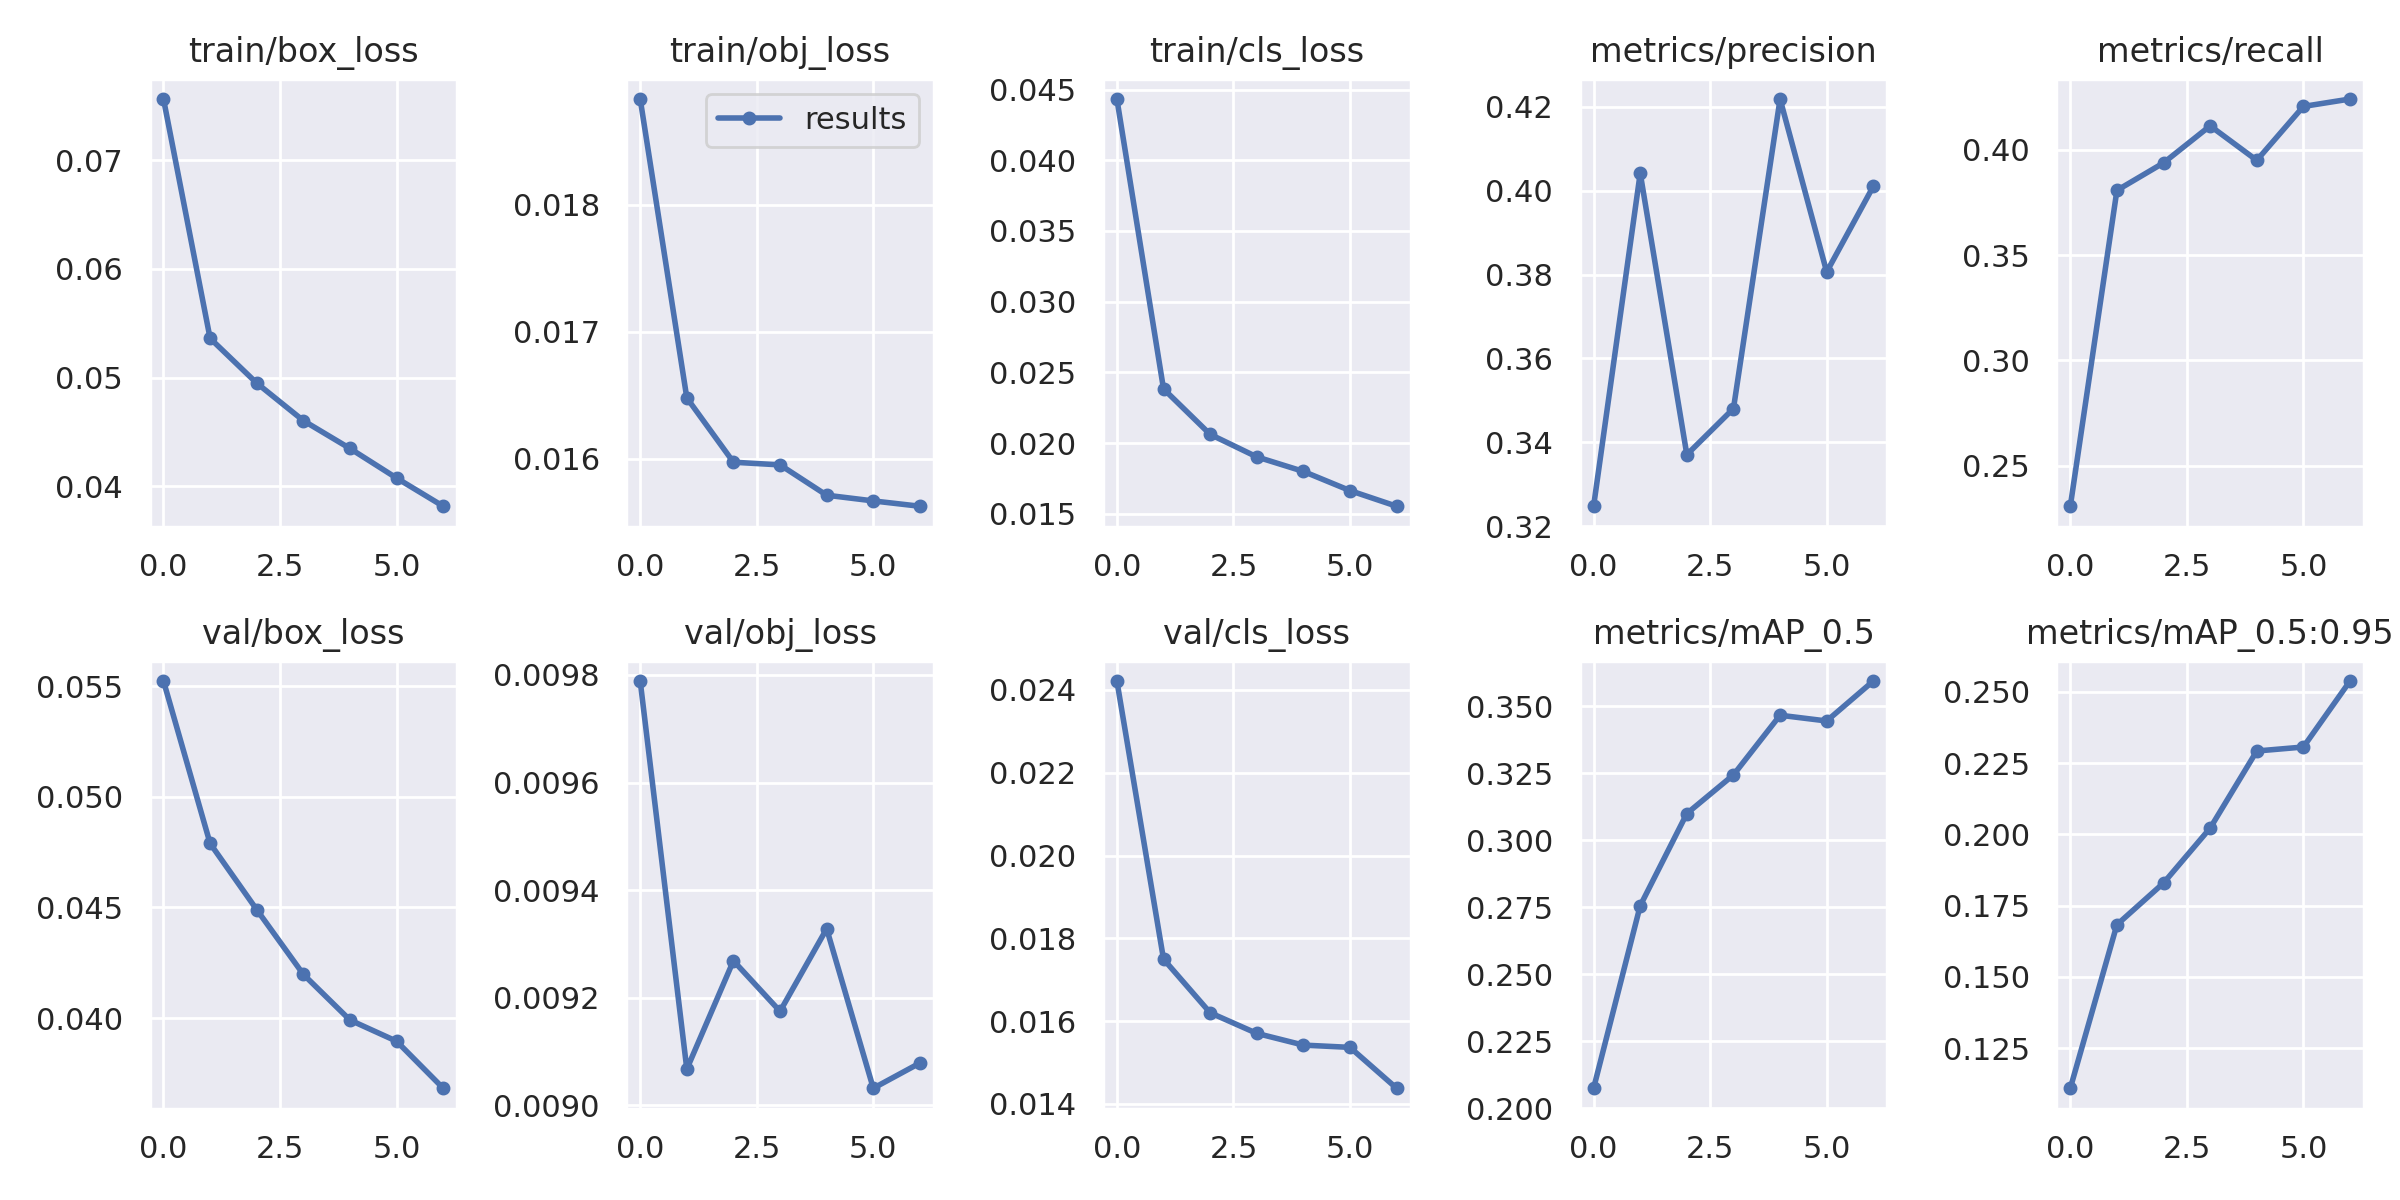

In [ ]:
#training ouput
display.Image(f"runs_traffic/feature_extraction4/results.png")

In [1]:
#yolo class to load model in pytorch and function to split video into frames, run yolo model on frame and later stitch those frames to get  with detected bounding boxes as ouput
class YOLO():
    """ CLASS FOR YOLOV5     """

    def __init__(self, model_path):
        #load yolov5 model trained on target tracking dataset
        device =  torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.model_path = model_path
        self.model = torch.hub.load('ultralytics/yolov5','custom', model_path).to(device) 
 


    def detect_video(self, video_path, save_video = True):
            
        frame_num = 0
        video = cv2.VideoCapture(video_path)

        out = {}
        frames_list =[]
        while True:
            ret, frame = video.read()
            
            

            if not ret:
                 break


            results = self.model(frame)

    
            results = results.pandas().xyxy[0].to_json(orient="records")
            results = json.loads(results )
    

            print("Frame : ", frame_num)
            print(results)
            print('---------------------')

            if len(results) > 0:
                for i in results:

                    #get coordinates and add them to json dict and draw rectangle on frame
                    xmin = int(round(int(i["xmin"]),0))
                    xmax = int(round(int(i["xmax"]),0))
                    ymin = int(round(int(i["ymin"]),0))
                    ymax = int(round(int(i["ymax"]),0))
                    cv2.rectangle(frame, (xmin, ymin),(xmax, ymax), (0, 255, 0), 3)
                    cv2.putText(frame, i['name'], (xmin, ymin-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (36,255,12), 2)

            frames_list.append(frame)
            frame_num += 1
            k = cv2.waitKey(30) & 0xff
            if k == 27:
                break


            
            video_name = video_path.split('/')[-1].split('.mp4')[0]
            if save_video:
            
                frames_shape = np.array(frames_list)
            

                out = cv2.VideoWriter(video_name + "_det.mp4", cv2.VideoWriter_fourcc(*'DIVX'), 30, (frames_shape.shape[2], frames_shape.shape[1]))

            for frame in frames_list:
                
                out.write(frame)

            out.release()

    


        video.release()
        cv2.destroyAllWindows()

    


In [2]:
#load model
yolo_model = YOLO("trained_weights.pt") #path for yolo parameters
yolo_model.detect_video("t.mp4") #path for video; gives video and json as output

NameError: ignored